In [1]:
import os
import json
import gradio as gr
import sqlite3
from dotenv import load_dotenv
from openai import OpenAI

In [2]:
load_dotenv(override=True)

openai_api_key = os.getenv("OPENAI_API_KEY")

if openai_api_key:
    print("API key loaded successfully")
else:
    print("Failed to load API key")

MODEL = "gpt-4.1-mini"
openai = OpenAI()
DB = "prices.db"

API key loaded successfully


In [3]:
system_message = """
You are a helpful assistant for an Airline called FlightAI.
Give short, courteous answers, no more than 1 sentence.
Always be accurate. If you don't know the answer, say so.
"""

In [4]:
def get_ticket_price(city):
    print(f"DATABASE TOOL CALLED: Getting ticket price for {city}", flush=True)

    with sqlite3.connect(DB) as conn:
        cursor = conn.cursor()
        cursor.execute("SELECT price FROM prices WHERE city = ?", (city.lower(),))
        result = cursor.fetchone()
        return f"Ticket price to {city} is ${result[0]}" if result else "No price data available for this city"

In [17]:
get_ticket_price("london")

DATABASE TOOL CALLED: Getting ticket price for london


'Ticket price to london is $$799'

In [5]:
price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city.",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "he city that the customer wants to travel to"
            }
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

tools = [{"type": "function", "function": price_function}]
tools

[{'type': 'function',
  'function': {'name': 'get_ticket_price',
   'description': 'Get the price of a return ticket to the destination city.',
   'parameters': {'type': 'object',
    'properties': {'destination_city': {'type': 'string',
      'description': 'he city that the customer wants to travel to'}},
    'required': ['destination_city'],
    'additionalProperties': False}}}]

In [12]:
def chat(message, history):
    history = [{"role": h["role"], "content": h["content"]} for h in history]
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

In [13]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [14]:
def handle_tool_calls(message):
    responses = []
    for tool_call in message.tool_calls:
        if tool_call.function.name == "get_ticket_price":
            arguments = json.loads(tool_call.function.arguments)
            city = arguments.get("destination_city")
            price_details = get_ticket_price(city)
            responses.append({
                "role": "tool",
                "content": price_details,
                "tool_call_id": tool_call.id
            })
    return responses

In [15]:
def chat(message, history):
    history = [{"role": h["role"], "content": h["content"]} for h in history]
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason == "tool_calls":
        message = response.choices[0].message
        responses = handle_tool_calls(message=message)
        messages.append(message)
        messages.extend(responses)
        response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    return response.choices[0].message.content

In [16]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


In [6]:
import base64
from io import BytesIO
from PIL import Image

In [7]:
def artist(city):
    image_response = openai.images.generate(
        model="dall-e-3",
        prompt=f"An image representing a vacation in {city}, showing tourist spots and everyhing unique about {city}, in a vibrant pop-art style",
        n=1,
        size="1024x1024",
        response_format="b64_json"
    )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

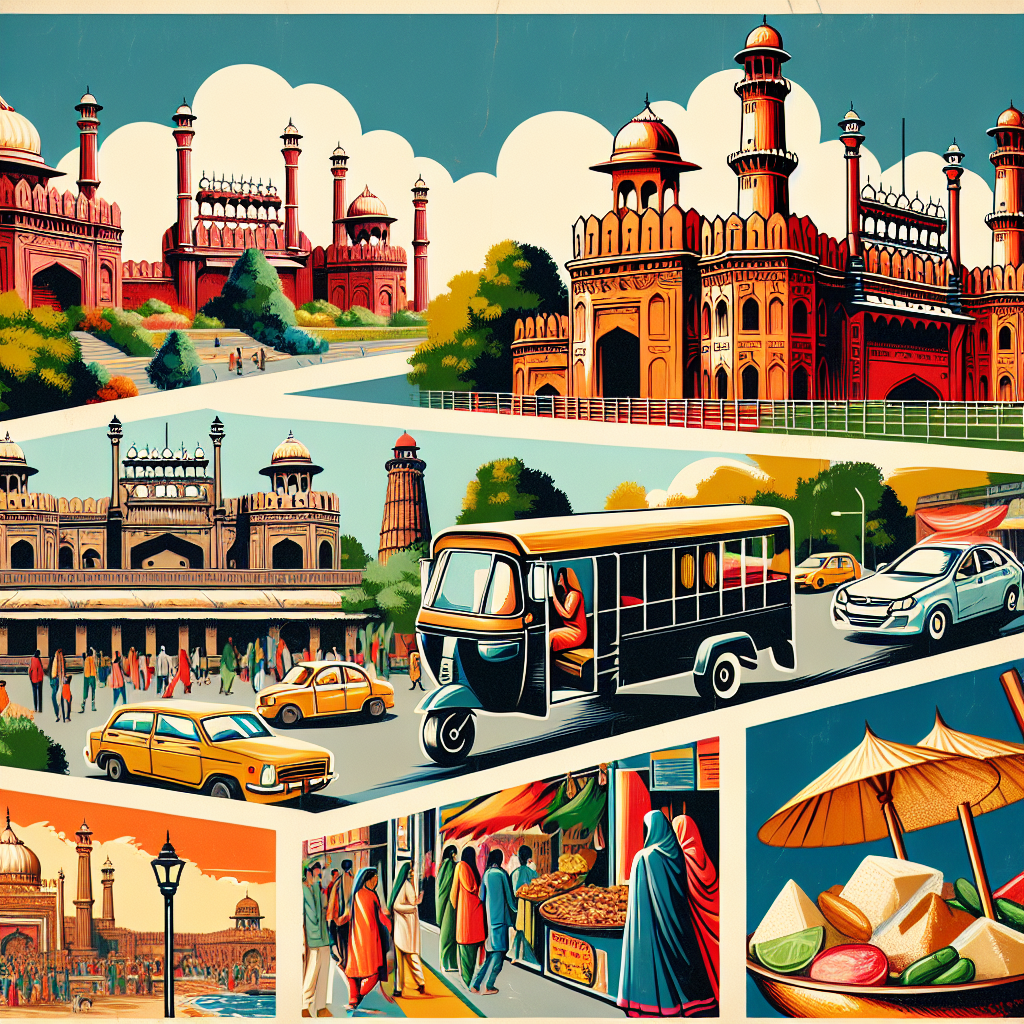

In [19]:
image = artist("Delhi")
display(image)

In [8]:
def talker(message):
    response = openai.audio.speech.create(
        model="gpt-4o-mini-tts",
        voice="alloy",
        input=message
    )
    return response.content

In [19]:
def handle_tool_calls_and_return_cities(message):
    responses = []
    cities = []
    for tool_call in message.tool_calls:
        if tool_call.function.name == "get_ticket_price":
            arguments = json.loads(tool_call.function.arguments)
            city = arguments.get("destination_city")
            price_details = get_ticket_price(city)
            cities.append(city)
            responses.append({
                "role": "tool",
                "content": price_details,
                "tool_call_id": tool_call.id
            })

    return responses, cities

In [13]:
def chat(history):
    history = [{"role": h["role"], "content": h["content"]} for h in history]
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    cities = []
    image = None

    while response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        responses, cities = handle_tool_calls_and_return_cities(message=message)
        messages.append(message)
        messages.extend(responses)
        response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    reply = response.choices[0].message.content
    history += [{"role": "assistant", "content": reply}]

    voice = talker(message=reply)

    if cities:
        image = artist(city=cities[0])

    return history, voice, image

In [20]:
# Callbacks (along with the chat() function above
def put_message_in_chatbot(message, history):
    return "", history + [{"role": "user", "content": message}]

# UI definition

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500, interactive=False)
    with gr.Row():
        audio_output = gr.Audio(autoplay=True)
    with gr.Row():
        message = gr.Textbox(label="Chat with our AI assistant")

    message.submit(put_message_in_chatbot, inputs=[message, chatbot], outputs=[message, chatbot]).then(
        chat, inputs=[chatbot], outputs=[chatbot, audio_output, image_output]
    )

    ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7866
* To create a public link, set `share=True` in `launch()`.
